In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [91]:
ValuesToForecast = 10
PastValuesToRefer = 100

ColumnToPredict = 'High'

In [92]:
dataset_train = pd.read_csv('EURJPY1440.csv',header=None)
dataset_train.columns = ['Date','Time','Open','High','Low','Close','Volume']

In [93]:
dataset_train.shape

(1025, 7)

In [94]:
dataset_train.tail()



,Date,Time,Open,High,Low,Close,Volume
1020,2021.03.23,00:00,129.829,129.913,128.587,128.588,12647
1021,2021.03.24,00:00,128.641,128.853,128.286,128.378,12560
1022,2021.03.25,00:00,128.389,128.938,128.373,128.380,13385
1023,2021.03.26,00:00,128.419,129.454,128.345,129.309,11866
1024,2021.03.29,00:00,129.333,129.430,129.136,129.194,1910


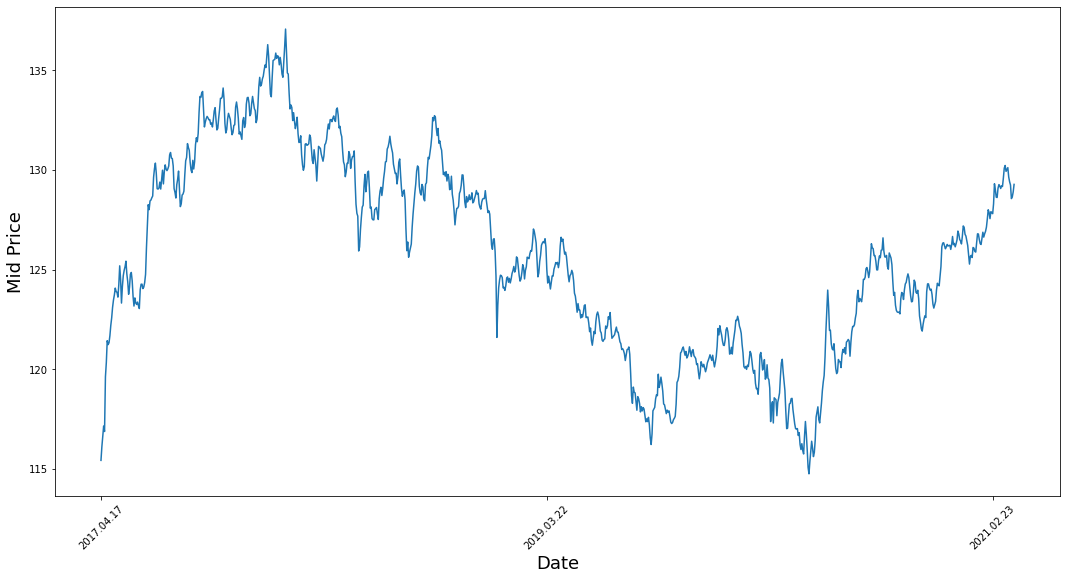

In [95]:
plt.figure(figsize = (18,9))
plt.plot(range(dataset_train.shape[0]),(dataset_train['Low']+dataset_train['High'])/2.0)
plt.xticks(range(0,dataset_train.shape[0],500),dataset_train['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [96]:
PlotDf = dataset_train[['Date',ColumnToPredict]]

In [97]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(dataset_train[ColumnToPredict].values.reshape(-1, 1))

In [98]:
stock_prices =stock_prices.astype('float32')


stock_prices = stock_prices.reshape(dataset_train.shape[0], 1)

In [99]:
from numpy import array

def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.values
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [100]:


X,y = to_supervised(pd.DataFrame(stock_prices),PastValuesToRefer,ValuesToForecast)

In [101]:
X = np.reshape(X, (X.shape[0],X.shape[1], 1 ))

In [102]:
X.shape

(916, 100, 1)

In [103]:
X[0].shape

(100, 1)

In [104]:
y.shape

(916, 10)

In [105]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

length = PastValuesToRefer
output = ValuesToForecast

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 20)           1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
29/29 [==============================] - 12s 99ms/step - loss: 0.3752
Epoch 2/50
29/29 [==============================] - 3s 94ms/step - loss: 0.1209
Epoch 3/50
29/29 [==============================] - 3s 108ms/step - loss: 0.0621
Epoch 4/50
29/29 [==============================] - 3s 105ms/step - loss: 0.0579
Epoch 5/50
29/29 [==============================] - 3s 106ms/step - loss: 0.0570
Epoch 6/50
29/29 [==============================] - 3s 100ms/step - loss: 0.0572
Epoch 7/50
29/29 [==============================] - 3s 100ms/step - loss: 0.0543
Epoch 8/50
29/29 [==============================] - 3s 108ms/step - loss: 0.0538
Epoch 9/50
29/29 [==============================] - 3s 110ms/step - loss: 0.0516
Epoch 10/50
29/29 [==============================] - 3s 99ms/step - loss: 0.0525
Epoch 11/50
29/29 [==============================] - 3s 102ms/step - loss: 0.0530
Epoch 12/50
29/29 [==============================] - 3s 112ms/step - loss: 0.0528
Epoch 13/50
29/29 [========

In [ ]:
from matplotlib import pyplot

yhat = model.predict(X, verbose=0)
pyplot.plot(y[0], label='y')
pyplot.plot(yhat[0], label='yhat')
pyplot.legend()
pyplot.show()

In [ ]:
TestObservation = dataset_train[ColumnToPredict].tail(PastValuesToRefer).values
TestObservation = scaler.transform(TestObservation.reshape(-1, 1))
TestObservation = TestObservation.reshape(1,PastValuesToRefer,1)
model.predict(TestObservation.reshape(1,50,1))

In [ ]:
scaler.inverse_transform(model.predict(TestObservation).reshape(-1,1))

In [ ]:
dataset_train.Date[len(dataset_train.Date)-1]

In [ ]:
OP = pd.DataFrame({'Date':pd.date_range(dataset_train.Date[len(dataset_train.Date) -1], periods=ValuesToForecast+1).tolist()})

In [ ]:
OP = OP.iloc[1:,]

In [ ]:
OP

In [ ]:
OP['Prediction'] = scaler.inverse_transform(model.predict(TestObservation).reshape(-1,1))

In [ ]:
OP = pd.concat([PlotDf,OP],axis=0)

In [ ]:
OP.set_index('Date', inplace=True)

In [ ]:
OP.tail(1000).plot()
plt.xticks(rotation=90)

In [ ]:
OP.tail(15)